In [1]:
import sys
import csv
import numpy as np
import pandas as pd
import cvxopt as co
from cvxopt import matrix
import pickle
import time
import os

In [2]:
obj = pd.read_pickle(r'D:/GitHub/COL774/Assignment 2/data/part2_data/train_data.pickle')

X_full_train = np.reshape(obj['data'],(len(obj['data']),32*32*3))
X_full_train = np.array(X_full_train,dtype = 'float64')
Y_full_train = np.reshape(obj['labels'],(10000,1))
X_full_train/=255

In [ ]:
def squaredDistanceMatrix(x, y, same=False):
    if same:
        squares = np.einsum('ij,ij->i', x, x)
        squares_fill = np.tile(squares, (squares.shape[0], 1))
        return squares_fill + squares_fill.T - 2 * np.matmul(x, x.T)
    squares_x = np.einsum('ij,ij->i', x, x)
    squares_y = np.einsum('ij,ij->i', y, y)
    return np.tile(squares_y, (squares_x.shape[0], 1)) + np.tile(squares_x, (squares_y.shape[0], 1)).T - 2 * np.matmul(x, y.T)

In [ ]:
def confusion_matrix(Y_test, Y_pred, k):
    confusion = np.zeros((k, k))
    for i, j in zip(Y_test, Y_pred):
#         print(i,j)
        confusion[int(i) - 1][int(j) - 1] += 1
    return confusion


In [ ]:
def testGaussian(x,x_sv,y_sv,gamma,alpha,b):
    
    nsv = x_sv.shape[0]
    m = x.shape[0]
    E = squaredDistanceMatrix(x_sv,x)
    Y_pred = np.einsum('i,ij->j', (alpha * y_sv).reshape(nsv,), np.exp(-gamma * E)) + b # np.sum(alpha*y_sv*np.exp(-gamma*E),axis = 0)+b
    return Y_pred.T

In [ ]:
def GaussianKernelSVM(x,y,C = 1.0,gamma = 0.001):    
    
    m = len(y)
    squares = np.exp(-gamma * squaredDistanceMatrix(x, x, same=True))
    #squares = np.exp(-gamma * squaredDistanceMatrixOld(x, x))
    P = co.matrix(squares * np.outer(y, y))
#     print(P)
#     q = co.matrix([-1.0] * m)
#     G = co.matrix(np.vstack((-1 * np.identity(m), np.identity(m))))
#     A = co.matrix([[y[i,0]] for i in range(m)])
#     b = co.matrix([0.0])
#     h = co.matrix([0.0] * m + [C] * m)
#     sol = co.solvers.qp(P, q, G, h, A, b, options={'show_progress': True})
#     assert sol['status'] == 'optimal'
#     print(sol['x'])
    
    '''m = x.shape[0]
#     X = np.square(np.linalg.norm(x,ord = 2,axis = 1)).reshape((m,1))
# #     print(X)
#     Z = np.ones((m,m))*X
#     X = Z + Z.T - 2*np.dot(x,x.T)    
    P = np.outer(y,y)*np.exp(-gamma*squaredDistanceMatrix(x,x,True))#np.exp(-gamma*X)
#     print(P)
    P = matrix(P)'''
    q = -np.ones((m,1))
    q = matrix(q)
    
    G = np.identity(m)
    G = np.append(G, -G, axis=0)
    G = matrix(G)
    
    h = np.ones((m,1))
    h = matrix(np.append(C * h, 0 * h, axis=0))
    
    A = matrix([[y[i,0]] for i in range(m)])
    b = matrix(0.0)
    
    sol = co.solvers.qp(P, q, G, h, A, b, options={'show_progress': True})
    
    alpha = (np.array(sol['x']).T)[0]
    
    
    

    value = np.einsum('i,i,ij->j', alpha, y.reshape((m,)), squares)
    

    inf = float('inf')
    mna, mxa = inf, -inf
    bSum = 0.0
    bNum = 0
    eps = 1e-5
    supportVectors = [i for i in range(m) if abs(alpha[i]) > eps]

    mna, mxa = -inf, inf
    
    for i in range(m):
        val = value[i]
        
        if int(y[i]) == -1:
            mna = max(mna, val)
        else:
            mxa = min(mxa, val)
    b = -(mna + mxa) / 2
    return b,supportVectors,alpha

In [ ]:
# One vs One CVXOPT

Classifiers = dict()

for i in range(5):
    for j in range(i+1,5):
        print(i,j)
        class1 = i
        class2 = j

        X_train = np.zeros((len(np.where(Y_full_train==class1)[0])+len(np.where(Y_full_train==class2)[0]),32*32*3))
        Y_train = np.zeros((len(np.where(Y_full_train==class1)[0])+len(np.where(Y_full_train==class2)[0]),1))

        X_train[0:len(np.where(Y_full_train==class1)[0])] = X_full_train[np.where(Y_full_train==class1)[0]]
        X_train[len(np.where(Y_full_train==class1)[0]):] = X_full_train[np.where(Y_full_train==class2)[0]]
        

        Y_train[0:len(np.where(Y_full_train==class1)[0])] = 1
        Y_train[len(np.where(Y_full_train==class1)[0]):] = -1
        
        b,supportVectors,alpha = GaussianKernelSVM(X_train,Y_train)
        Classifiers[(i,j)] = (b, supportVectors,alpha)
        
        


In [ ]:
print(Classifiers[(3,4)][0])

In [ ]:
# Test
obj = pd.read_pickle(r'D:/GitHub/COL774/Assignment 2/data/part2_data/test_data.pickle')

X_test = np.reshape(obj['data'],(len(obj['data']),32*32*3))
X_test = np.array(X_test,dtype = 'float64')
Y_test = np.reshape(obj['labels'],(len(obj['labels']),1))
X_test/=255

Y_pred = np.zeros((Y_test.shape[0],10))

binary_cfr_iter = 0


for i in range(5):
    for j in range(i+1,5):
#         print(i,j)
        
#         print(b)
        class1 = i
        class2 = j
        b,supportVectors,alpha = Classifiers[(class1,class2)]
        X_train = np.zeros((len(np.where(Y_full_train==class1)[0])+len(np.where(Y_full_train==class2)[0]),32*32*3))
        Y_train = np.zeros((len(np.where(Y_full_train==class1)[0])+len(np.where(Y_full_train==class2)[0]),1))

        X_train[0:len(np.where(Y_full_train==class1)[0])] = X_full_train[np.where(Y_full_train==class1)[0]]
        X_train[len(np.where(Y_full_train==class1)[0]):] = X_full_train[np.where(Y_full_train==class2)[0]]
        
        Y_train[0:len(np.where(Y_full_train==class1)[0])] = 1
        Y_train[len(np.where(Y_full_train==class1)[0]):] = -1
        
        Y_pred[:,binary_cfr_iter] = testGaussian(X_test,X_train[supportVectors],Y_train[supportVectors],0.001,alpha[supportVectors].reshape(-1,1),b)
        Y_pred[np.where(Y_pred[:,binary_cfr_iter]>=0)[0],binary_cfr_iter] = class1
        Y_pred[np.where(Y_pred[:,binary_cfr_iter]<0)[0],binary_cfr_iter] = class2
        binary_cfr_iter += 1

In [ ]:
m = Y_test.shape[0]
Predictions = np.zeros(m)
from scipy import stats as st
for i in range(m):
    Predictions[i] = st.mode(Y_pred[i])[0]


In [ ]:
acc = len(np.where(Predictions == Y_test.reshape(-1,))[0])
print(acc/len(Y_test))

In [ ]:
print(Y_test.reshape(-1,))

In [ ]:
print(confusion_matrix(Y_test.reshape(-1,),Predictions,5))

## Sklearn

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

clf =SVC(C = 1.0, kernel = 'rbf', gamma=0.001,decision_function_shape='ovo')
clf.fit(X_full_train,Y_full_train.reshape(-1,))
Predictions = (clf.predict(X_test))
acc = len(np.where(Predictions == Y_test.reshape(-1,))[0])
print(acc/len(Y_test))

In [ ]:
print(Predictions)

In [ ]:
print(confusion_matrix(Y_test.reshape(-1,),Predictions,5))

In [ ]:
training_data = np.concatenate((X_full_train,Y_full_train),axis = 1)

In [ ]:
np.random.shuffle(training_data)

In [ ]:
# No, you idiot.

# def kfoldcrossval(gamma):
#     folds = 5
#     m = Y_full_train.shape[0]
#     test_size = int(m/folds)
#     X_train = np.zeros((m-test_size,X_full_train.shape[1]))
#     X_test = np.zeros((test_size,X_full_train.shape[1]))
#     Y_train = np.zeros((m-test_size,Y_full_train.shape[1]))
#     Y_test = np.zeros((test_size,Y_full_train.shape[1]))
#     clf =SVC(C = 1.0, kernel = 'rbf', gamma=gamma,decision_function_shape='ovo')
#     acc = 0
#     for i in range(folds):
#         X_train[0:i*test_size] = training_data[0:i*test_size,0:-1]
#         Y_train[0:i*test_size] = training_data[0:i*test_size,-1:]
#         X_test[:] = training_data[i*test_size:(i+1)*test_size,0:-1]
#         Y_test[:] = training_data[i*test_size:(i+1)*test_size,-1:]
#         X_train[i*test_size:] = training_data[(i+1)*test_size:,0:-1]
#         Y_train[i*test_size:] = training_data[(i+1)*test_size:,-1:]
#         clf.fit(X_train,Y_train.reshape(-1,))
#         Predictions = (clf.predict(X_test))
#         acc += len(np.where(Predictions == Y_test.reshape(-1,))[0])/len(Y_test)
# #         print(acc/(i+1))
#     print(f"Val Accuracy : {acc/folds}")
#     obj = pd.read_pickle(r'D:/GitHub/COL774/Assignment 2/data/part2_data/test_data.pickle')

#     X_test = np.reshape(obj['data'],(len(obj['data']),32*32*3))
#     X_test = np.array(X_test,dtype = 'float64')
#     Y_test = np.reshape(obj['labels'],(len(obj['labels']),1))
#     X_test/=255
#     Predictions = (clf.predict(X_test))
#     acc = len(np.where(Predictions == Y_test.reshape(-1,))[0])
#     print(f"Test Accuracy : {acc/len(Y_test)}")
    

In [3]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
def kfoldcrossval(training_data,C,folds = 5):
    clf =SVC(C = C, kernel = 'rbf', gamma=0.001,decision_function_shape='ovo')
    valacc = 0
    i = 0
    for train_index, test_index in training_data:
        
        X_train, X_test = X_full_train[train_index], X_full_train[test_index]
        Y_train, Y_test = Y_full_train[train_index].reshape(-1,), Y_full_train[test_index].reshape(-1,)
        clf.fit(X_train,Y_train.reshape(-1,))
        Predictions = (clf.predict(X_test))
        valacc += len(np.where(Predictions == Y_test.reshape(-1,))[0])/len(Y_test)
        print(valacc/(i+1))
        i+=1
    valacc = valacc/folds
    print(f"Val Accuracy : {valacc}")
    obj = pd.read_pickle(r'D:/GitHub/COL774/Assignment 2/data/part2_data/test_data.pickle')

    X_test = np.reshape(obj['data'],(len(obj['data']),32*32*3))
    X_test = np.array(X_test,dtype = 'float64')
    Y_test = np.reshape(obj['labels'],(len(obj['labels']),1))
    X_test/=255
    clf.fit(X_full_train,Y_full_train.reshape(-1,))
    Predictions = (clf.predict(X_test))
    testacc = len(np.where(Predictions == Y_test.reshape(-1,))[0])/len(Y_test)
    print(f"Test Accuracy : {testacc}")
    return valacc,testacc 
    

In [27]:
from sklearn.model_selection import KFold
folds = 5
kf = KFold(n_splits=folds,shuffle = True)
ValAcc = np.zeros(6)
TestAcc = np.zeros(6)
for C,i in zip([1000],range(1)):
    print(f"C = {C}")
    training_data = kf.split(X_full_train)
    ValAcc[i],TestAcc[i] = kfoldcrossval(training_data,C,folds)

C = 1000
0.5805
0.5882499999999999
0.5901666666666666
0.58575
0.5843
Val Accuracy : 0.5843
Test Accuracy : 0.596


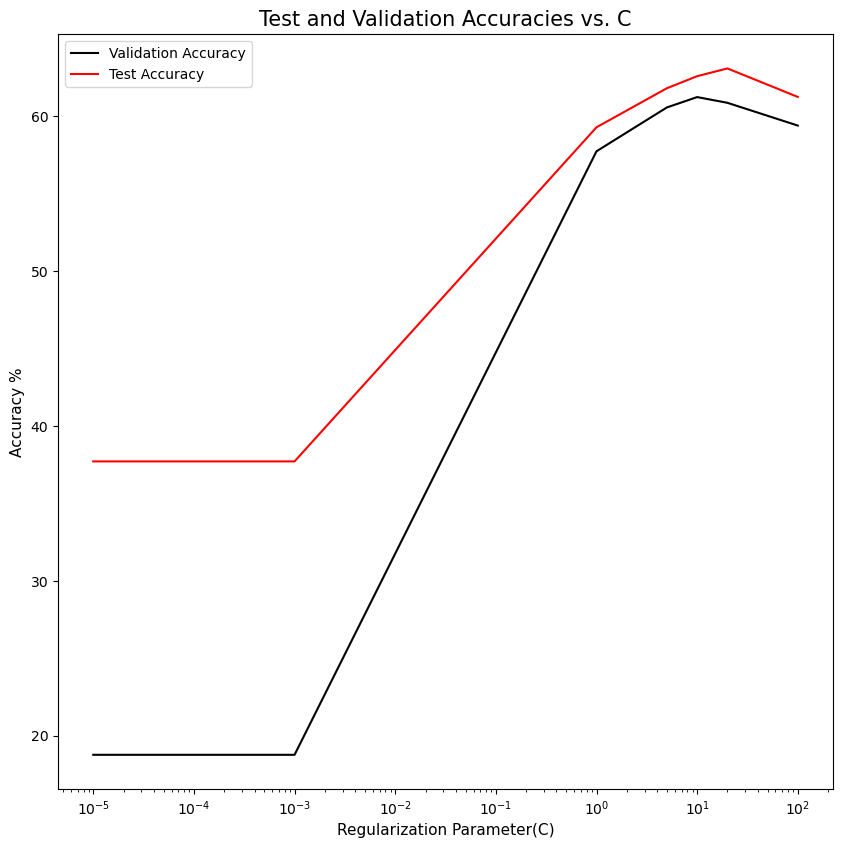

In [26]:
ValAcc = 100*np.array([ 0.18769999999999998, 0.18770000000000003,0.5775,0.6058,0.6125,0.6087999999999999,0.5941])
TestAcc = 100*np.array([ 0.3772,0.3772,0.593,0.6182,0.626,0.631,0.6126])
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize']=[10,10]
plt.rcParams.update({'font.size': 10})
fig,ax = plt.subplots()
plt.xscale('log')
ax.plot([1e-5,1e-3,1,5,10,20,100],ValAcc,c = 'black',label = "Validation Accuracy")
ax.plot([1e-5,1e-3,1,5,10,20,100],TestAcc,c = 'red',label = "Test Accuracy")
ax.set_title("Test and Validation Accuracies vs. C",fontsize=15)
ax.set_xlabel("Regularization Parameter(C)",fontsize = 11)
ax.set_ylabel("Accuracy %",fontsize = 11)
ax.legend()

plt.show()

C = 1e-05
0.1925
0.19025
0.1895
0.187625
0.18769999999999998
Val Accuracy : 0.18769999999999998
Test Accuracy : 0.3772
C = 0.001
0.1855
0.1825
0.18583333333333332
0.186875
0.18770000000000003
Val Accuracy : 0.18770000000000003
Test Accuracy : 0.3772
C = 1
0.5625
0.567
0.5675
0.576125
0.5775
Val Accuracy : 0.5775
Test Accuracy : 0.593
C = 5
0.6025
0.607
0.6036666666666667
0.60775
0.6058
Val Accuracy : 0.6058
Test Accuracy : 0.6182
C = 10
0.6205
0.61575
0.6135
0.6132500000000001
0.6125
Val Accuracy : 0.6125
Test Accuracy : 0.626
C = 20
0.6065
0.60175
0.6096666666666667
0.6054999999999999
0.6087999999999999
Val Accuracy : 0.6087999999999999
Test Accuracy : 0.631